In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import keras
import keras.models as M
import keras.layers as L
import keras.backend as K

2024-10-15 12:50:56.711023: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 12:50:56.756387: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 12:50:58.060589: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 12:50:58.451835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 12:50:59.355525: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## Чтение данных и их анализ

In [2]:
train_df = pd.read_csv("train.csv")
train_df = train_df.drop('ID', axis=1)
train_df.head()

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,49.207124,0,4.000000,162.996167,181.108682,0,0,148.227858,1,0.944547,2,0,3,1
1,53.628425,1,1.741596,130.233730,276.474630,0,2,152.917139,0,0.119070,2,0,3,0
2,49.591426,1,4.000000,146.999012,223.300517,1,2,102.352090,1,1.616747,2,2,7,1
3,58.991445,1,4.000000,112.369143,187.245501,0,0,158.164750,1,0.000000,1,1,7,1
4,51.053602,1,1.954609,138.032047,238.482868,0,0,172.540828,0,1.150464,1,1,3,0


Расшифровка столбцов данных:

1. Age (возраст);
2. Sex (пол);
3. Resting_blood_pressure (артериальное давление в состоянии покоя);
4. Serum_cholestoral (уровень холестерина в крови mg/dl);
5. Fasting_blood_sugar (анализ глюкозы в крови натощак (> 120 mg/dl));
6. Maximum_heart_rate_achieved (максимальная частота сердечных сокращений);
7. Exercise_induced_angina (стенокардия при нагрузке),
8. Oldpeak (депрессия ST-сегмента);
9. Slope (наклон пикового сегмента ST при физической нагрузке);
10. Number_of_major_vessels (количество крупных сосудов (0-3), окрашенных с помощью флюороскопии);
11. Resting_electrocardiographic_results (результаты электрокардиографических исследований в покое 0, 1, 2);
12. Thal (3 = норма; 6 = фиксированный дефект; 7 = обратимый дефект);
13. Chest_bin (боль в груди от 1 до 4).

In [3]:
train_df.info() #изучаем типы данных, а также смотрим во всех ли столбцах есть значения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   age                                   600000 non-null  float64
 1   sex                                   600000 non-null  int64  
 2   chest                                 600000 non-null  float64
 3   resting_blood_pressure                600000 non-null  float64
 4   serum_cholestoral                     600000 non-null  float64
 5   fasting_blood_sugar                   600000 non-null  int64  
 6   resting_electrocardiographic_results  600000 non-null  int64  
 7   maximum_heart_rate_achieved           600000 non-null  float64
 8   exercise_induced_angina               600000 non-null  int64  
 9   oldpeak                               600000 non-null  float64
 10  slope                                 600000 non-null  int64  
 11  

В наших данных нет отсутствующих значений.

Отталкиваясь от предоставленной расшифровки и общей логики, будем преобразовывать некоторые столбцы в другие форматы. 
Так, столбец с возрастом округлим до целого числа, так как не имеет смысла хранить точность возраста до шестой цифры после запятой.
Боль в груди разделим не категории от 1 до 4 с шагом в 0.5

In [4]:
def chest_pain(value):
    if value < 1.25:
        return 1
    elif (value > 1.25) and (value <= 1.75):
        return 1.5
    elif (value > 1.75) and (value <= 2.25):
        return 2
    elif (value > 2.25) and (value <= 2.75):
        return 2.5
    elif (value > 2.75) and (value <= 3.25):
        return 3
    elif (value > 3.25) and (value <= 3.75):
        return 3.5
    elif value > 3.75:
        return 4

In [5]:
train_df['age'] = train_df['age'].astype('int')
train_df['chest'] = train_df['chest'].apply(chest_pain)

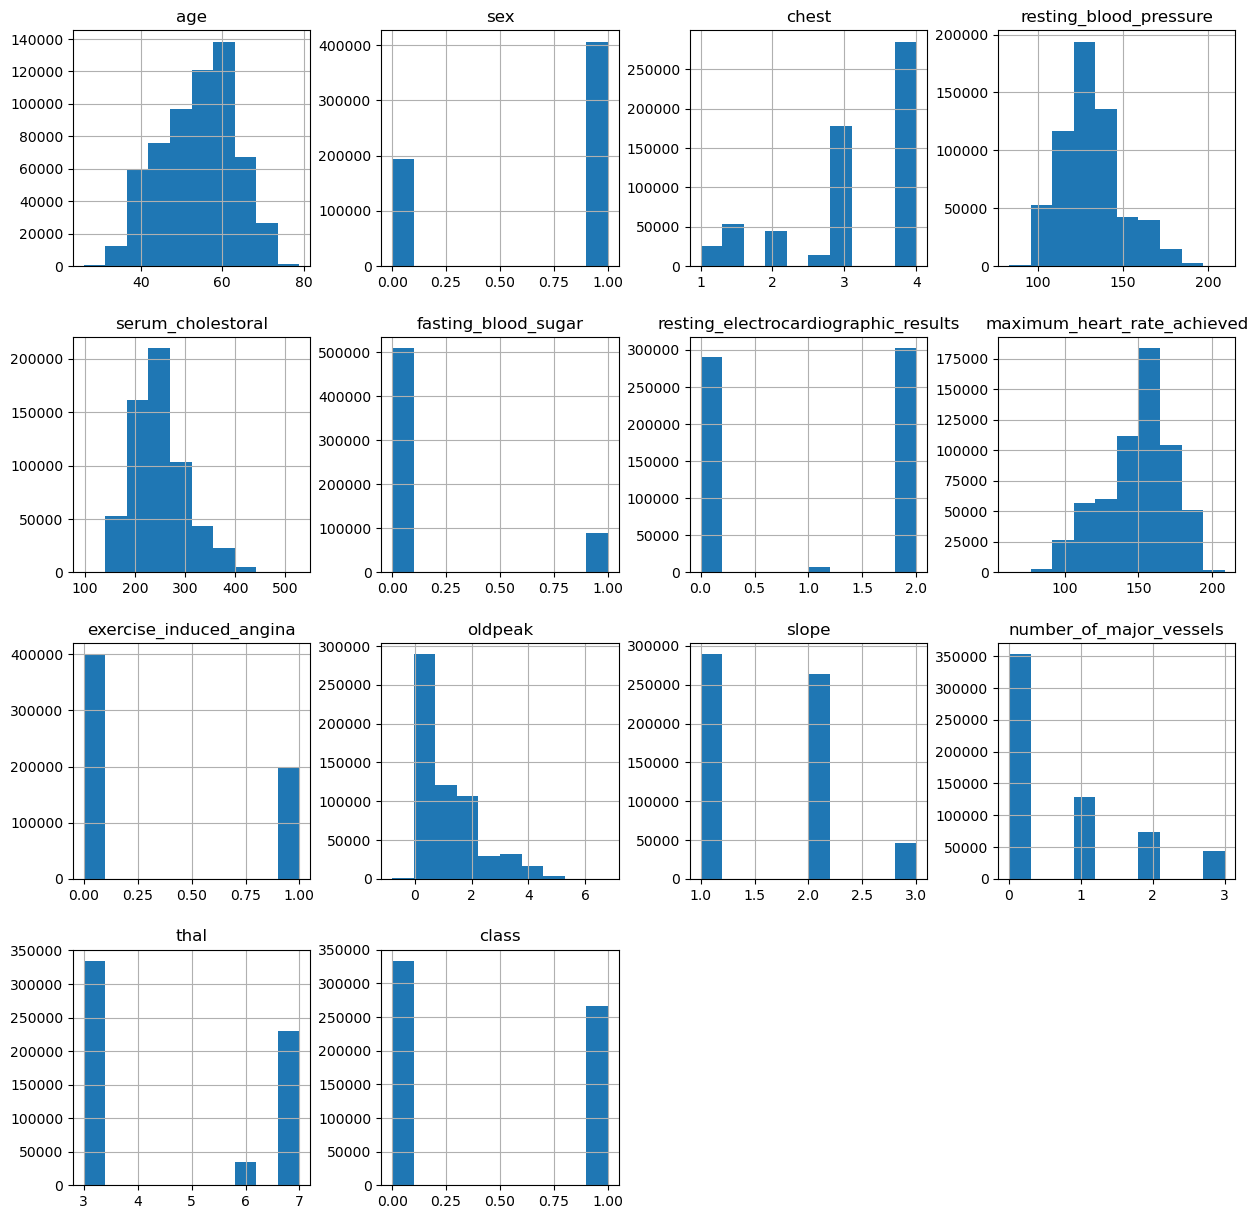

In [6]:
train_df.hist(figsize=(15,15));

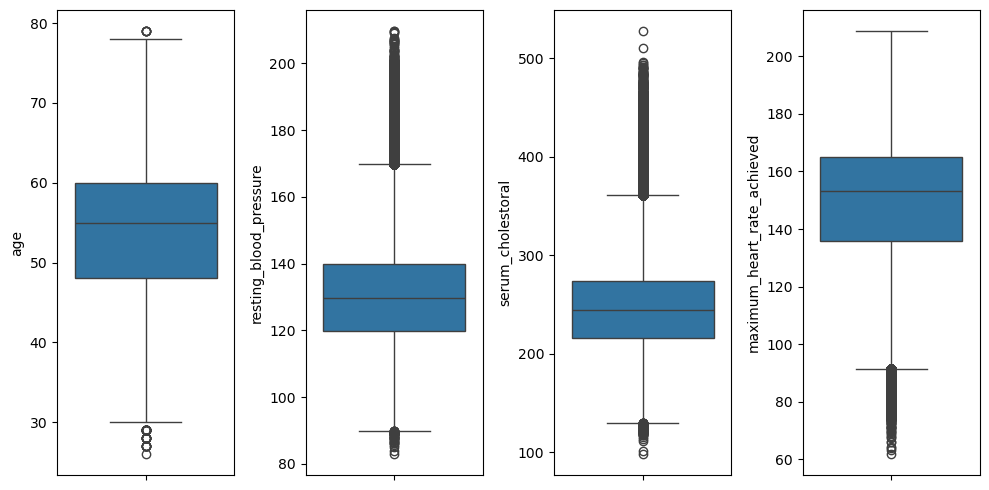

In [7]:
num_cols = ['age', 'resting_blood_pressure', 'serum_cholestoral', 'maximum_heart_rate_achieved']
plt.figure(figsize=(10,5))
for i in range(0,len(num_cols)):
    plt.subplot(1,len(num_cols),i+1)
    sns.boxplot(y=train_df[num_cols[i]])
    plt.tight_layout()

In [8]:
#Чистим данные от выбросов
for column_name in num_cols:
    Q1 = np.percentile(train_df[column_name], 25, interpolation='midpoint')
    Q3 = np.percentile(train_df[column_name], 75, interpolation='midpoint')

    IQR = Q3 - Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR

    outliers = train_df[(train_df[column_name] < low_lim) | (train_df[column_name] > up_lim)][column_name]

    train_df[column_name] = np.where(train_df[column_name] < low_lim, low_lim, train_df[column_name])
    train_df[column_name] = np.where(train_df[column_name] > up_lim, up_lim, train_df[column_name])

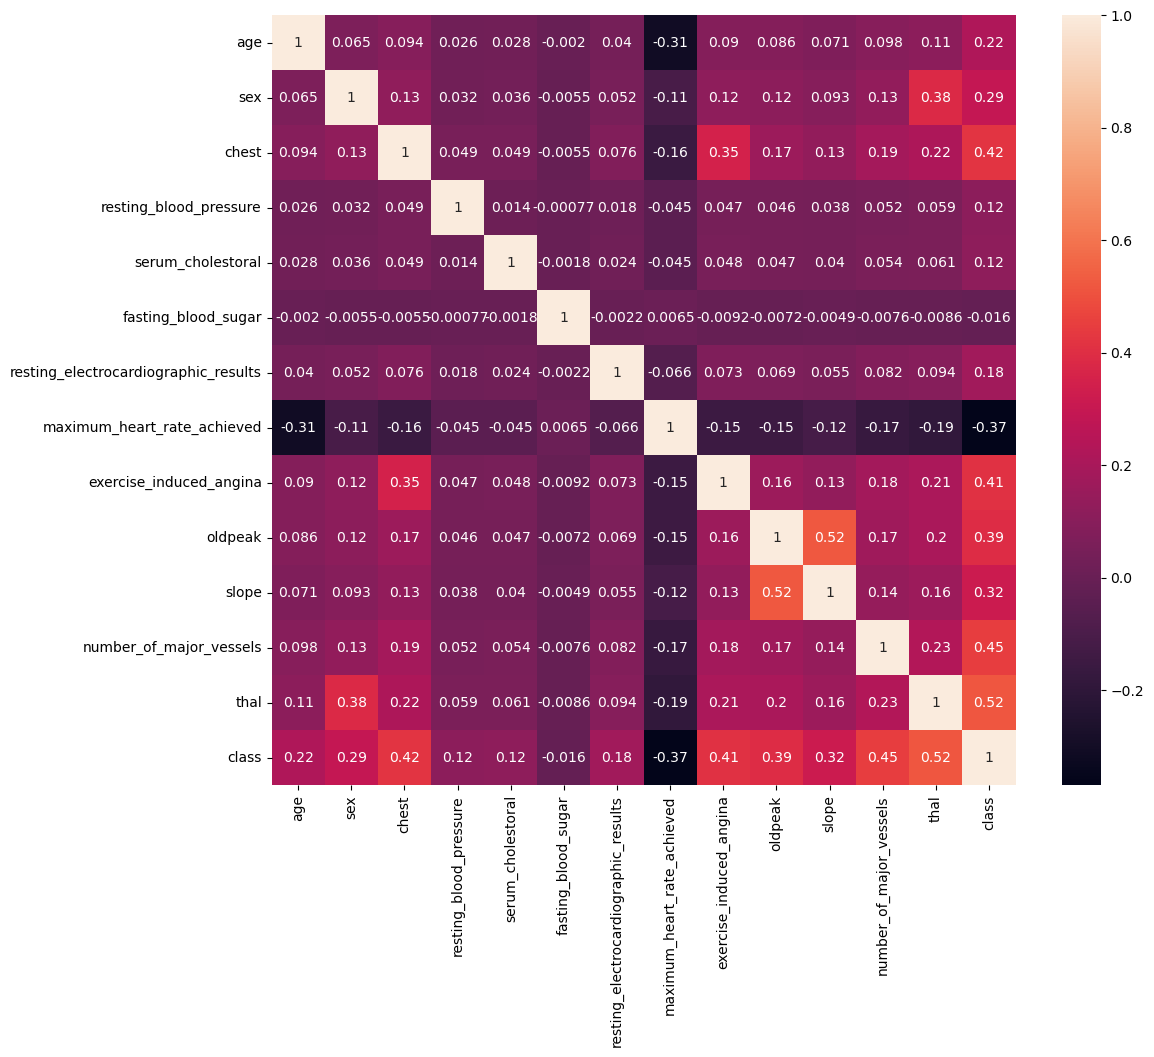

In [9]:
corrmat = train_df.corr()
plt.figure(figsize=(12, 10))
g = sns.heatmap(corrmat, annot=True, cmap="rocket")

In [10]:
#выбираем те признаки, у которых коэф.корреляции больше 0.2
high_corr_features=corrmat.index[abs(corrmat['class'])>=0.2]
high_corr_features_list = list(high_corr_features)
high_corr_features_list.remove('class')
high_corr_features_list

['age',
 'sex',
 'chest',
 'maximum_heart_rate_achieved',
 'exercise_induced_angina',
 'oldpeak',
 'slope',
 'number_of_major_vessels',
 'thal']

In [11]:
#делим исходный набор данных на матрицу наблюдений X (фичи) и столбец ответов y (таргет)
X = train_df[high_corr_features_list]
y = train_df['class']

Категориальными стобцами в наших интересующих нас стоблцах будут являться: chest, thal, number_of_major_vessels, slope. Для этих столбцов будем создавать фиктивные переменные. 

In [12]:
#Создаем фиктивные переменные для избранных столбцов
cat_cols=['chest', 'thal', 'number_of_major_vessels', 'slope']
X_dummies = pd.get_dummies(X, columns=cat_cols)
X_dummies.head()

,age,sex,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,chest_1.0,chest_1.5,chest_2.0,chest_2.5,chest_3.0,...,thal_3,thal_6,thal_7,number_of_major_vessels_0,number_of_major_vessels_1,number_of_major_vessels_2,number_of_major_vessels_3,slope_1,slope_2,slope_3
0,49.0,0,148.227858,1,0.944547,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
1,53.0,1,152.917139,0,0.119070,False,True,False,False,False,...,True,False,False,True,False,False,False,False,True,False
2,49.0,1,102.352090,1,1.616747,False,False,False,False,False,...,False,False,True,False,False,True,False,False,True,False
3,58.0,1,158.164750,1,0.000000,False,False,False,False,False,...,False,False,True,False,True,False,False,True,False,False
4,51.0,1,172.540828,0,1.150464,False,False,True,False,False,...,True,False,False,False,True,False,False,True,False,False


In [13]:
#делим данные на выборку тренировочных и тестовых данных
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, random_state=42, test_size=0.2)
#выводим формы данных
print('X_train', X_train.shape)
print('y_train', y_train.shape)

print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (480000, 22)
y_train (480000,)
X_test (120000, 22)
y_test (120000,)


## Стандартизируем данные

In [14]:
scl = StandardScaler()
xtrain_scl = scl.fit_transform(X_train)
xvalid_scl = scl.transform(X_test)

## Строим простую логистическую регрессию

In [15]:
log_reg = LogisticRegression(
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
log_reg.fit(xtrain_scl, y_train)

#Делаем предсказание
y_train_pred = log_reg.predict(xtrain_scl)
y_test_pred = log_reg.predict(xvalid_scl)

#Считаем метрику f1 на обучающей и тестовой выборках
print('Train f1_score: {:.3f}'.format(f1_score(y_train, y_train_pred)))
print('Test f1_score: {:.3f}'.format(f1_score(y_test, y_test_pred)))

Train f1_score: 0.869
Test f1_score: 0.867


## Строим случайный лес

In [16]:
rand_forest = RandomForestClassifier(n_estimators=10, max_depth=15, random_state=42)
rand_forest.fit(xtrain_scl, y_train)
# Делаем предсказание
y_train_pred = rand_forest.predict(xtrain_scl)
y_test_pred = rand_forest.predict(xvalid_scl)

# Считаем метрику f1 на обучающей и тестовой выборках
print('Train f1_score: {:.3f}'.format(f1_score(y_train, y_train_pred)))
print('Test f1_score: {:.3f}'.format(f1_score(y_test, y_test_pred)))

Train f1_score: 0.903
Test f1_score: 0.876


## Строим нейронную сеть на keras

In [17]:
K.clear_session()
model = M.Sequential()

model.add(L.Dense(64, activation='relu', input_shape=(22,)))
model.add(L.Dense(512, activation='relu'))
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(64, activation='relu'))
model.add(L.Dense(1, activation='sigmoid'))
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(xtrain_scl, y=y_train, batch_size=64, 
          epochs=10, verbose=1, 
          validation_data=(xvalid_scl, y_test))

/home/ashabalkina/.conda/envs/work_space/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,737 (424.75 KB)

 Trainable params: 108,737 (424.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8852 - loss: 0.2761 - val_accuracy: 0.8918 - val_loss: 0.2624
Epoch 2/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8928 - loss: 0.2593 - val_accuracy: 0.8917 - val_loss: 0.2612
Epoch 3/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8938 - loss: 0.2577 - val_accuracy: 0.8922 - val_loss: 0.2602
Epoch 4/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8945 - loss: 0.2549 - val_accuracy: 0.8931 - val_loss: 0.2578
Epoch 5/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8948 - loss: 0.2548 - val_accuracy: 0.8940 - val_loss: 0.2572
Epoch 6/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8950 - loss: 0.2537 - val_accuracy: 0.8937 - val_loss: 0.2563
Epoch 7/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8965 - loss: 0.2515 - val_accuracy: 0.8944 - val_loss: 0.2550
Epoch 8/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8960 - loss: 0

In [18]:
# Делаем предсказание
y_train_pred = model.predict(xtrain_scl)
y_test_pred = model.predict(xvalid_scl)

predicted_classes_test = (y_test_pred > 0.5).astype(int).flatten()
predicted_classes_train = (y_train_pred > 0.5).astype(int).flatten()
# Считаем метрику f1 на обучающей и тестовой выборках
print('Train f1_score: {:.3f}'.format(f1_score(y_train, predicted_classes_train)))
print('Test f1_score: {:.3f}'.format(f1_score(y_test, predicted_classes_test)))

15000/15000 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Train f1_score: 0.884
Test f1_score: 0.880


## График обучения 

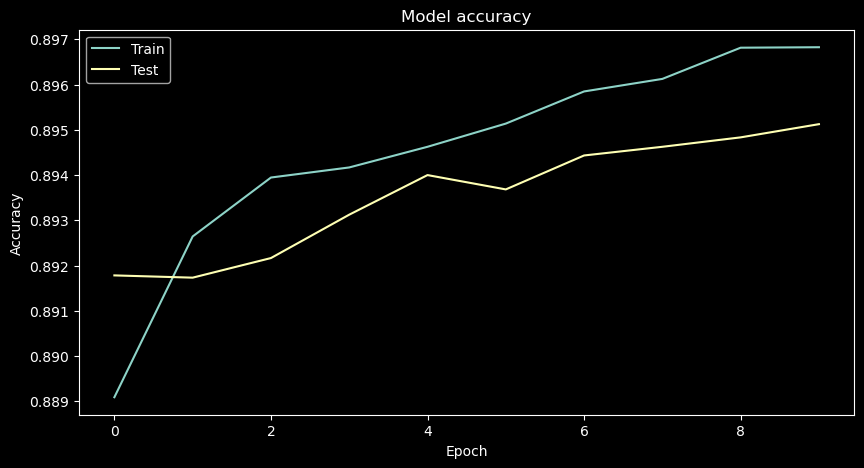

In [19]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Итог: разница между всеми тремя моделями 1-2% точности, лучший результат показала нейросеть

## Сохраняем инференс

In [22]:
keras.saving.save_model(
    model, 'nn_model.keras', overwrite=True
)

## Загружаем модель и тестовые данные 

In [26]:
test_df = pd.read_csv("test.csv")
test_df = test_df.drop('ID', axis=1)
test_df['age'] = test_df['age'].astype('int')
test_df['chest'] = test_df['chest'].apply(chest_pain)

for column_name in num_cols:
    Q1 = np.percentile(test_df[column_name], 25, interpolation='midpoint')
    Q3 = np.percentile(test_df[column_name], 75, interpolation='midpoint')

    IQR = Q3 - Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR

    outliers = test_df[(test_df[column_name] < low_lim) | (test_df[column_name] > up_lim)][column_name]

    test_df[column_name] = np.where(test_df[column_name] < low_lim, low_lim, test_df[column_name])
    test_df[column_name] = np.where(test_df[column_name] > up_lim, up_lim, test_df[column_name])
    
test = test_df[high_corr_features_list]  
test_dummies = pd.get_dummies(test, columns=cat_cols)
test_scl = scl.transform(test_dummies)

In [27]:
loaded_model = keras.saving.load_model("nn_model.keras")

In [28]:
test_pred = loaded_model.predict(test_scl)
test_pred_class = (test_pred > 0.5).astype(int).flatten()

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


In [33]:
test_df['pred_class'] = test_pred_class
test_df.head()

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,pred_class
0,53.0,1,4.0,136.940829,236.862814,0,2,143.961525,1,0.711100,1,2,7,1
1,49.0,1,4.0,122.024651,226.593019,0,2,112.220874,1,0.000000,1,1,7,1
2,36.0,1,1.5,127.585643,351.061046,0,0,177.945922,0,0.313078,1,0,7,0
3,54.0,1,3.0,124.876745,250.370530,0,0,153.176526,0,0.308277,1,1,7,0
4,71.0,0,1.5,120.922600,210.979710,0,0,164.573122,0,1.021370,1,1,3,0
